# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 50       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1924.697998046875
iteration 0 loss 376.04498291015625


iteration 5000 loss 0.23435673117637634


iteration 10000 loss 0.13060066103935242


iteration 15000 loss 0.10431763529777527


iteration 20000 loss 0.0770873948931694


iteration 25000 loss 0.06625974923372269


iteration 30000 loss 3.6436686515808105


iteration 35000 loss 0.3690091371536255


iteration 40000 loss 0.04749822989106178


iteration 45000 loss 0.043404221534729004


iteration 50000 loss 0.041005343198776245


iteration 55000 loss 0.038043707609176636


iteration 60000 loss 0.04200921207666397


iteration 65000 loss 0.03404376283288002


iteration 70000 loss 0.032607875764369965


iteration 75000 loss 0.031444139778614044


iteration 80000 loss 0.031132275238633156


iteration 85000 loss 0.029023077338933945


iteration 90000 loss 0.07232854515314102


iteration 95000 loss 0.02851051650941372


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.025968026369810104


iteration 105000 loss 0.025521481409668922


iteration 110000 loss 0.02472364529967308


iteration 115000 loss 0.024076249450445175


iteration 120000 loss 0.023475419729948044


iteration 125000 loss 0.0229438915848732


iteration 130000 loss 0.022420288994908333


iteration 135000 loss 0.021972384303808212


iteration 140000 loss 0.021566428244113922


iteration 145000 loss 0.021185066550970078


iteration 150000 loss 0.020830528810620308


iteration 155000 loss 0.020491966977715492


iteration 160000 loss 0.020197391510009766


iteration 165000 loss 0.01986066624522209


iteration 170000 loss 0.0203109011054039


iteration 175000 loss 0.01929784193634987


iteration 180000 loss 0.01902315393090248


iteration 185000 loss 0.01876133121550083


iteration 190000 loss 0.018515784293413162


iteration 195000 loss 0.018286867067217827


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.018093911930918694


iteration 205000 loss 0.017985738813877106


iteration 210000 loss 0.017748162150382996


iteration 215000 loss 0.0174909345805645


iteration 220000 loss 0.017603512853384018


iteration 225000 loss 0.017068633809685707


iteration 230000 loss 0.016873696818947792


iteration 235000 loss 0.016686633229255676


iteration 240000 loss 0.016508737578988075


iteration 245000 loss 0.01633831299841404


iteration 250000 loss 0.01617296412587166


iteration 255000 loss 0.016012176871299744


iteration 260000 loss 0.01585487648844719


iteration 265000 loss 0.01570284739136696


iteration 270000 loss 0.015561467967927456


iteration 275000 loss 0.015419669449329376


iteration 280000 loss 0.015281747095286846


iteration 285000 loss 0.015159509144723415


iteration 290000 loss 0.015020146034657955


iteration 295000 loss 0.014903578907251358


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.014776918105781078


iteration 305000 loss 0.014702687039971352


iteration 310000 loss 0.014543618075549603


iteration 315000 loss 0.014391973614692688


iteration 320000 loss 0.014244180172681808


iteration 325000 loss 0.014098122715950012


iteration 330000 loss 0.013955559581518173


iteration 335000 loss 0.013816592283546925


iteration 340000 loss 0.013681469485163689


iteration 345000 loss 0.013551151379942894


iteration 350000 loss 0.013425170443952084


iteration 355000 loss 0.013303417712450027


iteration 360000 loss 0.013186654075980186


iteration 365000 loss 0.013073992915451527


iteration 370000 loss 0.012965042144060135


iteration 375000 loss 0.012858783826231956


iteration 380000 loss 0.012756142765283585


iteration 385000 loss 0.012655786238610744


iteration 390000 loss 0.012558299116790295


iteration 395000 loss 0.01246347650885582


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.012371161952614784


iteration 405000 loss 0.012354194186627865


iteration 410000 loss 0.012332380749285221


iteration 415000 loss 0.012311391532421112


iteration 420000 loss 0.012290874496102333


iteration 425000 loss 0.012270703911781311


iteration 430000 loss 0.012250781059265137


iteration 435000 loss 0.012231077067553997


iteration 440000 loss 0.012211550958454609


iteration 445000 loss 0.012192168273031712


iteration 450000 loss 0.012172935530543327


iteration 455000 loss 0.012153824791312218


iteration 460000 loss 0.01213484164327383


iteration 465000 loss 0.012115980498492718


iteration 470000 loss 0.01209722924977541


iteration 475000 loss 0.012078548781573772


iteration 480000 loss 0.012059933505952358


iteration 485000 loss 0.012041401118040085


iteration 490000 loss 0.012022939510643482


iteration 495000 loss 0.012004539370536804


L2 loss -- Plot

loss -83.13334655761719


loss -257.44854736328125


loss -344.14849853515625


loss -418.1080627441406


loss -483.3628234863281


loss -535.964599609375


loss -575.2301635742188


loss -605.392822265625


loss -628.70849609375


loss -646.8543701171875


loss -659.983642578125


loss -669.796142578125


loss -676.9088134765625


loss -681.3564453125


loss -683.9261474609375


loss -685.4656372070312


loss -686.4176025390625


loss -686.9898681640625


loss -687.3232421875


loss -687.5011596679688


loss -687.58056640625


loss -687.60498046875


loss -687.6096801757812


loss -687.6102294921875


loss -687.6102294921875


loss -687.6102294921875


loss -687.6102294921875


loss -687.6102905273438


loss -687.6102905273438


loss -687.6102905273438


loss -687.6102905273438


loss -687.6102294921875


loss -687.6102905273438


loss -687.6102905273438


loss -687.6102905273438


loss -687.6103515625


loss -687.6102294921875


loss -687.6102294921875


loss -687.6102905273438


loss -687.6103515625


final mse:  1.0527362093171178e-08
max, min: 5.8196826 -7.4167013
loss -83.13334655761719


loss -251.23895263671875


loss -334.69873046875


loss -410.93157958984375


loss -476.6954650878906


loss -534.1041259765625


loss -580.6619873046875


loss -614.9402465820312


loss -641.7708129882812


loss -662.7291259765625


loss -678.5628051757812


loss -689.6004638671875


loss -697.4761962890625


loss -703.0303955078125


loss -706.699951171875


loss -709.111572265625


loss -710.6632080078125


loss -711.56689453125


loss -711.9862670898438


loss -712.1480102539062


loss -712.2088623046875


loss -712.230712890625


loss -712.2366943359375


loss -712.2378540039062


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379150390625


loss -712.2379760742188


loss -712.2379150390625


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379760742188


loss -712.2379150390625


loss -712.2379760742188


final mse:  6.293368937093646e-09
max, min: 6.684219 -7.4599338


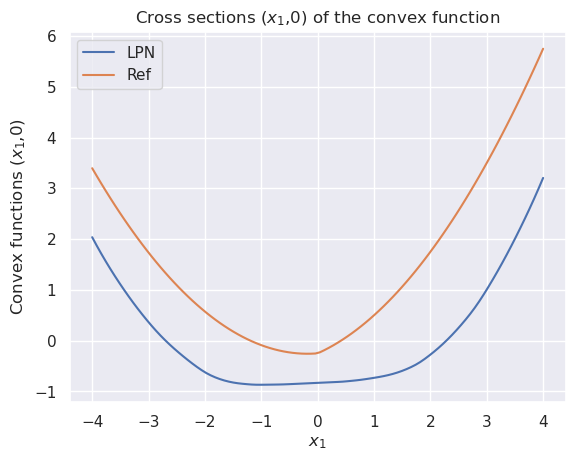

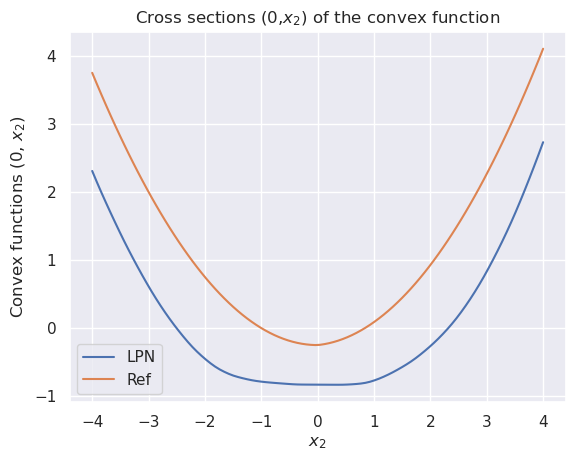

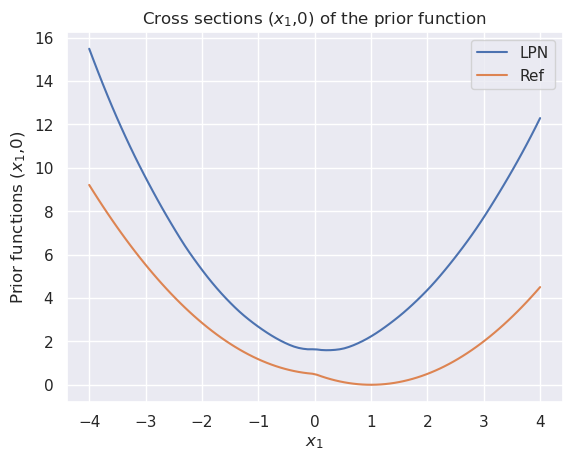

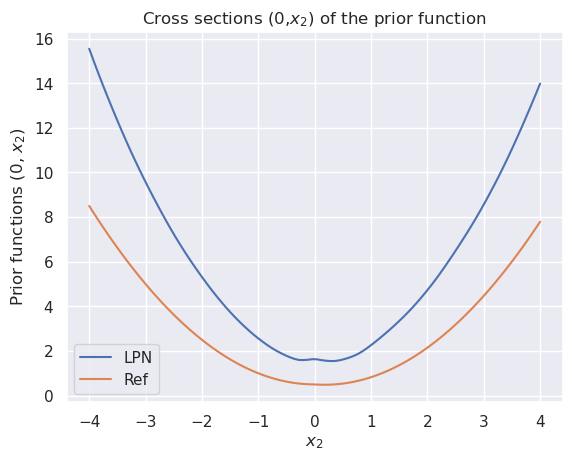

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1656.3988037109375
iteration 0 loss 791.59716796875


iteration 5000 loss 4.592965126037598


iteration 10000 loss 0.29638051986694336


iteration 15000 loss 0.17798322439193726


iteration 20000 loss 0.14230486750602722


iteration 25000 loss 0.12520284950733185


iteration 30000 loss 0.11445526033639908


iteration 35000 loss 0.1079910397529602


iteration 40000 loss 0.10279150307178497


iteration 45000 loss 0.09817633777856827


iteration 50000 loss 0.09410396218299866


iteration 55000 loss 0.09098948538303375


iteration 60000 loss 0.08796011656522751


iteration 65000 loss 0.08501792699098587


iteration 70000 loss 0.08237549662590027


iteration 75000 loss 0.08013400435447693


iteration 80000 loss 0.07792805880308151


iteration 85000 loss 0.07560613006353378


iteration 90000 loss 0.07345156371593475


iteration 95000 loss 0.0711730569601059


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.06903516501188278


iteration 105000 loss 0.06776502728462219


iteration 110000 loss 0.06505680829286575


iteration 115000 loss 0.06257561594247818


iteration 120000 loss 0.060252249240875244


iteration 125000 loss 0.057883281260728836


iteration 130000 loss 0.05563172325491905


iteration 135000 loss 0.05344734340906143


iteration 140000 loss 0.051478613168001175


iteration 145000 loss 0.04956323280930519


iteration 150000 loss 0.04774833843111992


iteration 155000 loss 0.04604778066277504


iteration 160000 loss 0.044589120894670486


iteration 165000 loss 0.04314560443162918


iteration 170000 loss 0.04180660843849182


iteration 175000 loss 0.040607523173093796


iteration 180000 loss 0.03937198966741562


iteration 185000 loss 0.038324832916259766


iteration 190000 loss 0.03731191158294678


iteration 195000 loss 0.03635010868310928


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.035478051751852036


iteration 205000 loss 0.03527853265404701


iteration 210000 loss 0.03455911949276924


iteration 215000 loss 0.03383695334196091


iteration 220000 loss 0.033159997314214706


iteration 225000 loss 0.032522182911634445


iteration 230000 loss 0.031915418803691864


iteration 235000 loss 0.03134073317050934


iteration 240000 loss 0.030792992562055588


iteration 245000 loss 0.030271286144852638


iteration 250000 loss 0.029776083305478096


iteration 255000 loss 0.02930171974003315


iteration 260000 loss 0.028845952823758125


iteration 265000 loss 0.02840813435614109


iteration 270000 loss 0.027987927198410034


iteration 275000 loss 0.027580387890338898


iteration 280000 loss 0.02718653529882431


iteration 285000 loss 0.02680944837629795


iteration 290000 loss 0.026446642354130745


iteration 295000 loss 0.026099303737282753


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.02576560527086258


iteration 305000 loss 0.025718078017234802


iteration 310000 loss 0.02566337212920189


iteration 315000 loss 0.025610769167542458


iteration 320000 loss 0.025559401139616966


iteration 325000 loss 0.025508923456072807


iteration 330000 loss 0.02545914798974991


iteration 335000 loss 0.025409944355487823


iteration 340000 loss 0.025361189618706703


iteration 345000 loss 0.025312835350632668


iteration 350000 loss 0.025264877825975418


iteration 355000 loss 0.025217292830348015


iteration 360000 loss 0.025170058012008667


iteration 365000 loss 0.025123175233602524


iteration 370000 loss 0.02507653832435608


iteration 375000 loss 0.025030212476849556


iteration 380000 loss 0.02498416043817997


iteration 385000 loss 0.024938397109508514


iteration 390000 loss 0.02489294670522213


iteration 395000 loss 0.024847807362675667


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.024802975356578827


iteration 405000 loss 0.024798840284347534


iteration 410000 loss 0.024794721975922585


iteration 415000 loss 0.024790648370981216


iteration 420000 loss 0.024786602705717087


iteration 425000 loss 0.0247825738042593


iteration 430000 loss 0.024778567254543304


iteration 435000 loss 0.02477457746863365


iteration 440000 loss 0.024770598858594894


iteration 445000 loss 0.024766627699136734


iteration 450000 loss 0.024762678891420364


iteration 455000 loss 0.024758733808994293


iteration 460000 loss 0.02475481480360031


iteration 465000 loss 0.02475089393556118


iteration 470000 loss 0.0247469712048769


iteration 475000 loss 0.024743087589740753


iteration 480000 loss 0.024739202111959457


iteration 485000 loss 0.024735314771533012


iteration 490000 loss 0.02473144792020321


iteration 495000 loss 0.02472759038209915


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


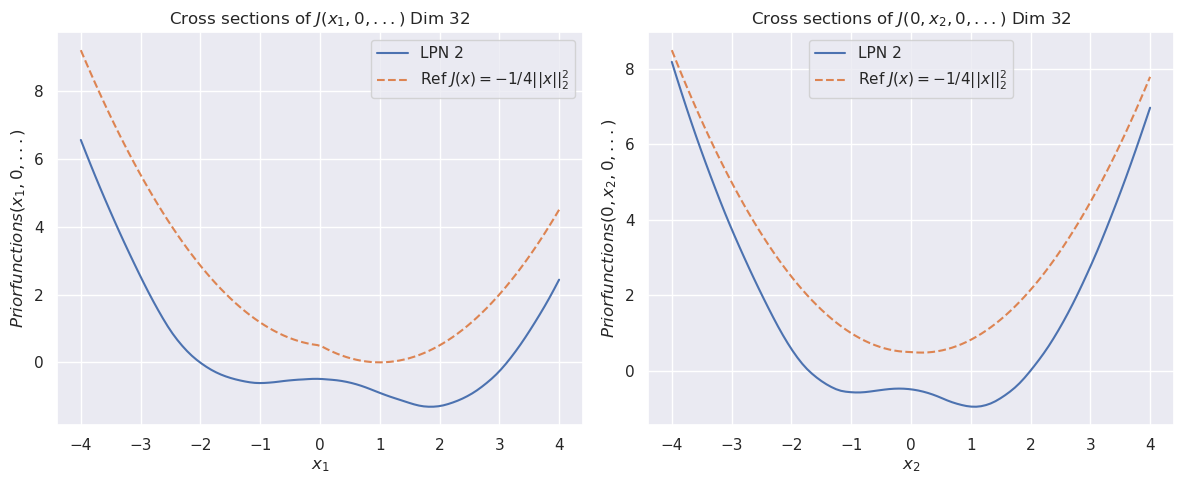

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)